In [1]:
%reload_ext autoreload
%autoreload 2
# %matplotlib qt
%matplotlib inline

import random
import numpy as np
import torch
from matplotlib import pyplot as plt
from syd import make_viewer, Viewer
from tqdm import tqdm

from vrAnalysis.database import get_database
from vrAnalysis.helpers import Timer, format_spines, beeswarm, errorPlot, save_figure
from vrAnalysis.processors.placefields import get_placefield
from dimilibi import PCA, SVCA
from dimensionality_manuscript.registry import PopulationRegistry, get_subspace, SubspaceName
from dimensionality_manuscript.regression_models.hyperparameters import PlaceFieldHyperparameters

plt.rcParams["font.size"] = 14

# get session database
sessiondb = get_database("vrSessions")

# get population registry and models
registry = PopulationRegistry()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
SUBSPACE_NAMES: list[SubspaceName] = [
    "svca_subspace",
    "covcov_subspace",
]
subspaces = [get_subspace(name, registry, match_dimensions=False) for name in SUBSPACE_NAMES]
spks_type = "oasis"
sessiondb = get_database("vrSessions")
registry = PopulationRegistry()

specific_hyperparameters = PlaceFieldHyperparameters(num_bins=100, smooth_width=None)

num_sessions = len(sessiondb.iter_sessions(imaging=True))
mouse_names = []
model_metrics = [[] for _ in subspaces]
for isession, session in enumerate(tqdm(sessiondb.iter_sessions(imaging=True, session_params=dict(spks_type=spks_type)))):
    mouse_names.append(session.mouse_name)
    for imodel, model in enumerate(subspaces):
        metrics = model.get_score(session, spks_type=spks_type, hyperparameters=specific_hyperparameters)
        model_metrics[imodel].append(metrics)
mouse_names = np.array(mouse_names)

score = np.full((len(subspaces), len(mouse_names)), np.nan)
varact, varpos = [], []
for i in range(len(subspaces)):
    c_scores = np.array([m["evaluation_score"] for m in model_metrics[i]])
    c_varact = [m["variance_activity"] for m in model_metrics[i]]
    c_varpos = [m["variance_placefields"] for m in model_metrics[i]]
    score[i] = c_scores
    varact.append(c_varact)
    varpos.append(c_varpos)

max_dims = max([len(v) for v in varact[0]+varact[1]])
varact_pad = np.full((len(subspaces), len(mouse_names), max_dims), np.nan)
varpos_pad = np.full((len(subspaces), len(mouse_names), max_dims), np.nan)
for i in range(len(subspaces)):
    for j in range(len(mouse_names)):
        varact_pad[i, j, :len(varact[i][j])] = varact[i][j]
        varpos_pad[i, j, :len(varpos[i][j])] = varpos[i][j]

mice = list(set(mouse_names))
avg_scores = np.full((len(SUBSPACE_NAMES), len(mice)), np.nan)
avg_varact = np.full((len(SUBSPACE_NAMES), len(mice), max_dims), np.nan)
avg_varpos = np.full((len(SUBSPACE_NAMES), len(mice), max_dims), np.nan)
for imodel, model_name in enumerate(SUBSPACE_NAMES):
    for imouse, mouse in enumerate(mice):
        if np.sum(mouse_names == mouse) == 0:
            print(f"No sessions for {mouse} with model {model_name}")
        avg_scores[imodel, imouse] = np.mean(score[imodel][mouse_names == mouse])
        avg_varact[imodel, imouse] = np.nanmean(varact_pad[imodel][mouse_names == mouse], axis=0)
        avg_varpos[imodel, imouse] = np.nanmean(varpos_pad[imodel][mouse_names == mouse], axis=0)

100%|██████████| 149/149 [00:00<00:00, 1031.18it/s]
C:\Users\Andrew\AppData\Local\Temp\ipykernel_28856\1254089472.py:49: RuntimeWarning: Mean of empty slice
  avg_varact[imodel, imouse] = np.nanmean(varact_pad[imodel][mouse_names == mouse], axis=0)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_28856\1254089472.py:50: RuntimeWarning: Mean of empty slice
  avg_varpos[imodel, imouse] = np.nanmean(varpos_pad[imodel][mouse_names == mouse], axis=0)


C:\Users\Andrew\AppData\Local\Temp\ipykernel_28856\1829969585.py:8: RuntimeWarning: invalid value encountered in log
  pow_func_log = lambda x, A, M: np.log(A) - M * np.log(x)
C:\Users\Andrew\Documents\GitHub\vrAnalysis\vrAnalysis\helpers\plotting.py:80: RuntimeWarning: Mean of empty slice
  meanData = mean(data, axis=axis)
c:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


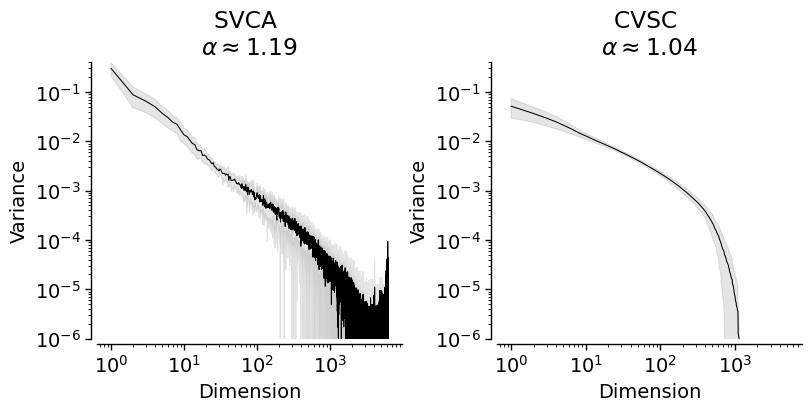

In [72]:
from scipy.optimize import curve_fit

total_variance = np.nansum(avg_varact, axis=2, keepdims=True)
norm_data_activity = avg_varact / total_variance

x_offset = 10
x_last = 400
pow_func_log = lambda x, A, M: np.log(A) - M * np.log(x)

def get_fit(data: np.ndarray):
    num_bins = data.shape[0]
    mask = ~np.isnan(data) & (data > 0) & (np.arange(num_bins) >= x_offset) & (np.arange(num_bins) <= x_last)
    ydata = data[mask]
    ydata = ydata / np.nansum(data)
    xdata_fit = np.arange(num_bins)[mask] + 1

    popt, _ = curve_fit(pow_func_log, xdata_fit, np.log(ydata), p0=[1.0, 5.0])
    mse = np.mean((pow_func_log(xdata_fit, *popt) - ydata)**2)

    return popt[0], popt[1], mse
    
amplitude = np.full((norm_data_activity.shape[0], norm_data_activity.shape[1]), np.nan)
shape = np.full((norm_data_activity.shape[0], norm_data_activity.shape[1]), np.nan)
mse = np.full((norm_data_activity.shape[0], norm_data_activity.shape[1]), np.nan)
for i in range(norm_data_activity.shape[0]):
    for j in range(norm_data_activity.shape[1]):
        amplitude[i, j], shape[i, j], mse[i, j] = get_fit(norm_data_activity[i, j])

idx_model = 1 # Use the COVCOV model
idx_mouse = 6 
beewidth = 0.2
full_color = "black"
placefield_color = "orange"
ylim = (1e-6, 4e-1)

alpha = np.nanmean(shape, axis=1)

plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(8, 4), layout="constrained")

for imodel, model_name in enumerate(["SVCA", "CVSC"]):
    errorPlot(range(1, max_dims+1), norm_data_activity[imodel], axis=0, ax=ax[imodel], se=False, color=full_color, label="Full", linewidth=0.75, alpha=0.1)
    # ax[1].plot(range(1, max_dims+1), norm_data_activity[imodel].T, color=full_color, label="Full", linewidth=0.75)
    ax[imodel].set_xscale('log')
    ax[imodel].set_yscale('log')
    ax[imodel].set_ylim(ylim)
    ax[imodel].set_xlabel("Dimension")
    ax[imodel].set_ylabel("Variance")
    ax[imodel].set_title(f"{model_name} \n" + r"$\alpha\approx$" + f"{alpha[imodel]:.2f}")
    format_spines(ax[imodel], x_pos=-0.02, y_pos=-0.02)

figure_path = registry.registry_paths.figure_path / "svca_analysis" / f"svca_covcov_basic_figure"
save_figure(fig, figure_path)

plt.show()

5.323793102765853 5.740715295255056 5.323793102765866


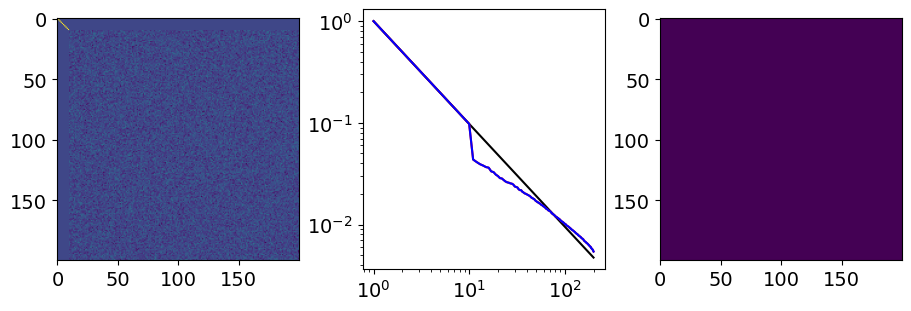

In [207]:
N = 200
num_same = 10
Q = np.linalg.qr(np.random.randn(N, N))[0]
Q1 = Q.copy()
Q2 = Q.copy()
R1 = np.linalg.qr(np.random.randn(N-num_same, N-num_same))[0]
R2 = np.linalg.qr(np.random.randn(N-num_same, N-num_same))[0]
Q1[:, num_same:] = Q1[:, num_same:] @ R1
Q2[:, num_same:] = Q2[:, num_same:] @ R2
Q1 = Q1 / np.linalg.norm(Q1, axis=0, keepdims=True)
Q2 = Q2 / np.linalg.norm(Q2, axis=0, keepdims=True)

# Construct a diagonal matrix with elements 2^{n}, ..., 2^{1} for n = N
V = np.diag(np.arange(1, N+1) ** (-1.01))

# Looking at C1r C2 C1r
mix = Q1.T @ Q2
M = Q1 @ np.sqrt(V) @ Q1.T @ Q2 @ V @ Q2.T @ Q1 @ np.sqrt(V) @ Q1.T
meval = np.sqrt(np.linalg.eigvalsh(M)[::-1])
V121 = np.sqrt(np.linalg.eigvalsh(np.sqrt(V) @ mix @ V @ mix.T @ np.sqrt(V))[::-1])
V121full = np.diag(V121)
print(np.sum(V121), np.sum(V), np.sum(meval))

fig, ax = plt.subplots(1, 3, figsize=(9, 3), layout="constrained")
ax[0].imshow(mix)
ax[2].imshow(V121full - np.diag(np.diag(V121full)))
ax[1].plot(range(1, N+1), np.diag(V), color="k", label="original")
ax[1].plot(range(1, N+1), V121, color="red", label="mixed")
ax[1].plot(range(1, N+1), meval, color="blue", label="M")
ax[1].set_xscale('log')
ax[1].set_yscale('log')
plt.show()


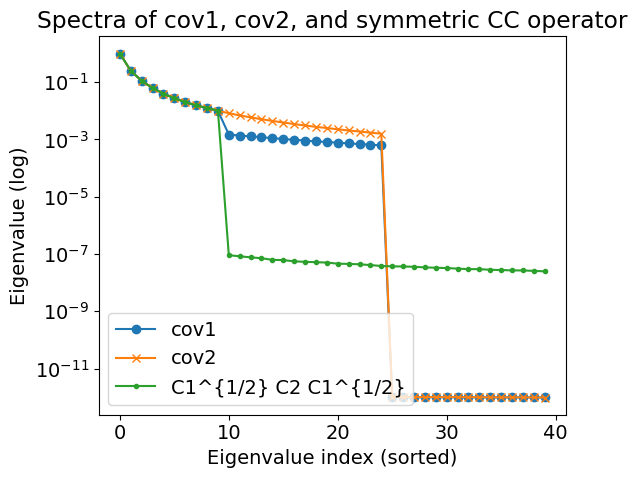

In [ ]:
import numpy as np
from scipy.linalg import expm
from matplotlib import pyplot as plt

def small_limited_rotation(N, eps=0.1):
    G = np.random.default_rng().standard_normal((N, N))
    A = G - G.T           # skew-symmetric
    R = expm(eps * A)     # orthogonal and close to I
    return R

def eigh_clipped(A, eps=0):
    V, Q = np.linalg.eigh(A)
    V = np.maximum(V, eps)
    return V, Q

def matrix_root(A, eps=0):
    V, Q = eigh_clipped(A, eps)
    return Q @ np.diag(np.sqrt(V)) @ Q.T

def build_qv(Q, V, match, rotate, idx, eps=0.1, zero_value=1e-9):
    # start with the same q
    q = Q.copy()
    v = V.copy()
    N = q.shape[0]
    if N - (match + rotate) < 2:
        raise ValueError("Not enough space for independent eigenvalues")

    # rotate some eigenvectors (after the matched ones)
    rotate_q = q[:, match:match+rotate]
    small_rotation = small_limited_rotation(rotate, eps=eps)
    new_rotate_q = rotate_q @ small_rotation
    q[:, match:match+rotate] = new_rotate_q

    # remaining eigenvectors are the same---
    # but we zero out the first/second half of remaining eigenvalues based on idx
    num_remaining = N - match - rotate
    idx_offset = num_remaining // 2
    num_independent = num_remaining // 2 if idx == 0 else num_remaining - num_remaining // 2
    idx_zero = np.arange(num_independent) + match + rotate + idx * idx_offset
    v[idx_zero] = zero_value

    return q, v

def create_data(N, S, q=None, v=None):
    if q is None:
        q = np.linalg.qr(np.random.randn(N, N))[0]
    if v is None:
        v = 1e3 * (np.arange(N) + 1) ** (-1.01)
    s = np.random.randn(N, S)
    return q @ np.diag(v) @ s

# ----- your setup -----
N = 40
S = 100000
alpha = 1.0001
scale = 1e0
match = 5
rotate = 5
eps_rotate = 0.1
zero_value = 1e-6

Q = np.linalg.qr(np.random.randn(N, N))[0]
V = scale * (np.arange(N) + 1) ** (-alpha)
Q1, V1 = build_qv(Q, V, match, rotate, 0, eps=eps_rotate, zero_value=zero_value)
Q2, V2 = build_qv(Q, V, match, rotate, 1, eps=eps_rotate, zero_value=zero_value)
    
data1 = create_data(N, S, q=Q1, v=V1)
data2 = create_data(N, S, q=Q2, v=V2)

cov1 = np.cov(data1)
cov2 = np.cov(data2)
cov1r = matrix_root(cov1)

c12 = cov1 @ cov2
c121 = cov1r @ cov2 @ cov1r

# eigenspectra
evals1, _ = eigh_clipped(cov1)
evals2, _ = eigh_clipped(cov2)
evals_cc_sym, evecs_cc_sym = eigh_clipped(c121)
evals_cc_sym = np.sqrt(evals_cc_sym)

# ---- Plot 2: spectra of cov1, cov2, and CC symmetric operator ----
plt.figure(figsize=(6, 5))
plt.plot(np.sort(evals1)[::-1], marker="o", linestyle="-", label="cov1")
plt.plot(np.sort(evals2)[::-1], marker="x", linestyle="-", label="cov2")
plt.plot(np.sort(evals_cc_sym)[::-1], marker=".", linestyle="-", label="C1^{1/2} C2 C1^{1/2}")
plt.yscale("log")
# plt.ylim(0, 0.02)
plt.xlabel("Eigenvalue index (sorted)")
plt.ylabel("Eigenvalue (log)")
plt.title("Spectra of cov1, cov2, and symmetric CC operator")
plt.legend()
plt.tight_layout()